In [57]:
import os
os.chdir('/mnt/data/akshit.jain/user_clicks/')

In [9]:
import pandas as pd
import fastavro
import numpy as np

def avro_df(filepath, encoding='rb'):
    # Open file stream
    with open(filepath, encoding) as fp:
        # Configure Avro reader
        reader = fastavro.reader(fp)
        # Load records in memory
        records = [r for r in reader]
        # Populate pandas.DataFrame with records
        df = pd.DataFrame.from_records(records)
        # Return created DataFrame
        return df

In [56]:
df=avro_df('/mnt/data/akshit.jain/user_clicks/user_clicks_19_aug_20q.avro')

KeyboardInterrupt: 

In [11]:
print("user x fsn clicks are: {}".format(df.shape[0]))
print("unique fsns are: {}".format(len(df.fsn.unique())))
print("unique users are: {}".format(len(df.userId.unique())))

user x fsn clicks are: 3172879
unique fsns are: 494553
unique users are: 684094


In [26]:
_df=df[df.store.str.contains('2oq/s9b/mg4')]

In [27]:
fsns=_df.groupby('userId').apply(lambda x: x.fsn.tolist()).to_frame('fsns').reset_index()
fsns['num']=fsns.fsns.apply(len)
fsns=fsns.sort_values('num', ascending=False).reset_index(drop=True)

In [40]:
_fsns=fsns[(fsns.num>1) & (fsns.num<10)]

In [35]:
debug_fsns=fsns[fsns.num==4].sample(n=1).iloc[0].fsns
def print_urls():
    for fsn in debug_fsns:
        print("http://www.flipkart.com/item/{}".format(fsn))
print_urls()

http://www.flipkart.com/item/SHTF5ZZHKBCZJ7SJ
http://www.flipkart.com/item/SHTEZANEF6UZFZKG
http://www.flipkart.com/item/SHTETNFPYJHJEFHA
http://www.flipkart.com/item/SHTF5WJHZBYNWRTY


In [6]:
(_fsns[_fsns.num<50].shape[0]*10000)//_fsns.shape[0]/100

99.39

In [41]:
# filter user * clicks to contain only sanitized data
_df=_df[_df.userId.isin(_fsns.userId)]

In [47]:
from math import ceil
print("we are taking {0:.2f}% of data".format((_df.shape[0]*100)/df.shape[0]))

we are taking 2.92% of data


In [48]:
# we will break only into test and train. val is same as test. let's not loose too much of data.
unique_users = pd.Series(_df.userId.unique()).to_frame('userId')
unique_users['id']=unique_users.index
unique_fsns = pd.Series(_df.fsn.unique()).to_frame('fsn')
unique_fsns['id']=unique_fsns.index

In [49]:
denorm_df=pd.merge(_df, unique_fsns, how='inner', on='fsn').merge(unique_users, on='userId', suffixes=('_fsn', '_user'))

In [59]:
denorm_df.to_pickle('/mnt/data/akshit.jain/user_clicks/data_df.pk')
# denorm_df = pd.read_pickle('/mnt/data/akshit.jain/user_clicks/data_df.pk')

In [51]:
final_df=denorm_df[['id_fsn','id_user']]

In [52]:
final_df=final_df.sample(frac=1.0)

In [53]:
TEST_FRAC=0.00
TRAIN_FRAC=1-TEST_FRAC
DATA_SIZE=final_df.shape[0]
TRAIN_SIZE=int(TRAIN_FRAC*DATA_SIZE)
TEST_SIZE=DATA_SIZE-TRAIN_SIZE
train_df = final_df[:TRAIN_SIZE]
test_df = val_df = final_df[TRAIN_SIZE:]

In [54]:
# train_dat = None
# test_dat = None
train_dat=np.asarray(train_df.rename(columns={'id_fsn':'item_id','id_user':'user_id'}).to_records(index=False))
test_dat=np.asarray(test_df.rename(columns={'id_fsn':'item_id','id_user':'user_id'}).to_records(index=False))

In [58]:
import pickle as pk
data={'train': train_dat,'test':test_dat}
with open('/mnt/data/akshit.jain/user_clicks/train_test.dat', 'wb') as f:
    pk.dump(data,f)

In [16]:
from openrec.utils import ImplicitDataset

train_dataset = ImplicitDataset(raw_data=train_dat, 
                        max_user=unique_users.shape[0], 
                        max_item=unique_fsns.shape[0], name='Train')
# NOTE: we are using same dataset for train and val
val_dataset = ImplicitDataset(raw_data=test_dat, 
                      max_user=unique_users.shape[0],
                      max_item=unique_fsns.shape[0], name='Val')
test_dataset = ImplicitDataset(raw_data=test_dat, 
                       max_user=unique_users.shape[0],
                       max_item=unique_fsns.shape[0], name='Test')

In [40]:
unique_fsns.shape[0]

48444

In [29]:
import tensorflow as tf
tf.reset_default_graph()

In [30]:
from openrec.recommenders import BPR

bpr_model = BPR(batch_size=1000, 
                max_user=train_dataset.max_user(), 
                max_item=train_dataset.max_item(), 
                dim_embed=20, 
                opt='Adam')

In [31]:
from openrec.utils.samplers import PairwiseSampler

sampler = PairwiseSampler(batch_size=1000, dataset=train_dataset, num_process=1) 

In [32]:
from openrec.utils.evaluators import AUC

auc_evaluator = AUC()

In [33]:
from openrec import ImplicitModelTrainer

model_trainer = ImplicitModelTrainer(batch_size=1000, 
                             test_batch_size=1000, 
                            train_dataset=train_dataset, 
                             model=bpr_model, 
                             sampler=sampler)

In [60]:
model_trainer.train(num_itr=10000, 
                    display_itr=1000, 
                    eval_datasets=[val_dataset, test_dataset],
                    evaluators=[auc_evaluator])

# Evaluate model

In [61]:
import os
os.chdir('/mnt/data/akshit.jain/user_clicks/bpr')

In [62]:
import tensorflow as tf
from openrec.recommenders import BPR

import numpy as np
import pickle as pk
import pandas as pd
with open('./train_test.dat','rb') as f:
    data=pk.load(f)

NUM_USERS=len(np.unique(data['train']['user_id']))
NUM_ITEMS=len(np.unique(data['train']['item_id']))

tf.reset_default_graph()
bpr_model = BPR(batch_size=1000, 
                max_user=NUM_USERS, 
                max_item=NUM_ITEMS, 
                dim_embed=20, 
                opt='Adam')
bpr_model.load('./bpr-shirts-10000')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [63]:
df=pd.read_pickle('data_df.pk')

In [67]:
fsn_meta = pd.read_pickle('../fsn_meta.pk')[['fsn','title']]

In [73]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
import os.path as osp

IMAGE_DIR='../../visual_reco/product_images/'
def plot_images(_fsns):
    _fsns=list(_fsns)
    imgs=[mpimg.imread(osp.join(IMAGE_DIR, f+'.jpg')) for f in _fsns]
    N_COLS=5#min(len(fsns),5)
    N_ROWS=(len(_fsns)+N_COLS-1)//N_COLS
    PLOT_WIDTH=17
    PLOT_HEIGHT=1.5*int(N_ROWS*(PLOT_WIDTH/N_COLS))
    f, axarr = plt.subplots(N_ROWS, N_COLS, squeeze=False, figsize=(PLOT_WIDTH,PLOT_HEIGHT))
    [(ax.get_xaxis().set_visible(False), ax.get_yaxis().set_visible(False), ax.axis('off')) for ax in f.axes]
    
    f.tight_layout()
    for idx, fsn in enumerate(_fsns):
        plt.axis('off')
        plot_row = idx//N_COLS
        plot_col = idx%N_COLS
        axarr[plot_row,plot_col].imshow(imgs[idx])
        title=fsn_meta[fsn_meta.fsn==_fsns[idx]].iloc[0].title
        axarr[plot_row,plot_col].set_title(title)
    #plt.savefig('similar_demo_3.png')
    plt.show()

In [71]:
from random import randint

DBG_USER=np.random.randint(NUM_USERS)
dat=data['train']
dat[dat['user_id']==DBG_USER]

in_dat=np.array([(DBG_USER,)], dtype=[('user_id_input', 'i8')])
scores=bpr_model.serve(in_dat)[0]
top_n=np.argsort(-scores)[:20]

clicked_fsn=df[df.id_user==DBG_USER].fsn.unique()
rec_fsn=df[df.id_fsn.isin(top_n)].fsn.unique()
# rec_fsn = frozenset(fsns.fsn.iloc[top_n].values)-frozenset(clicked_fsn)

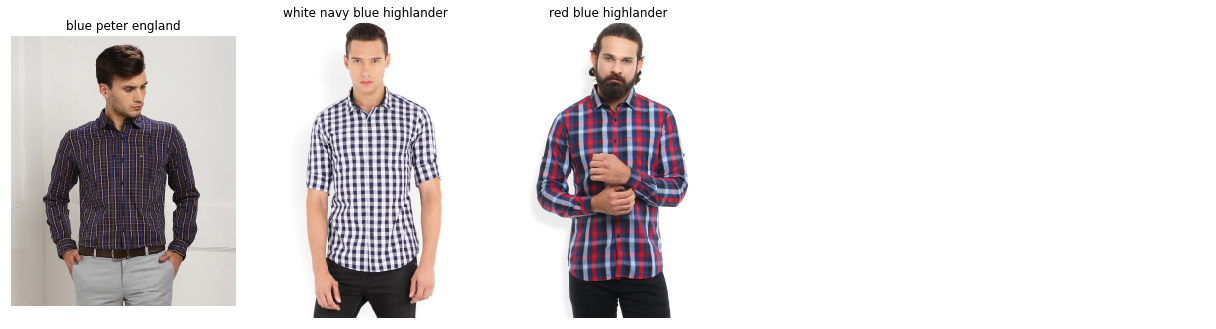

In [74]:
plot_images(clicked_fsn)

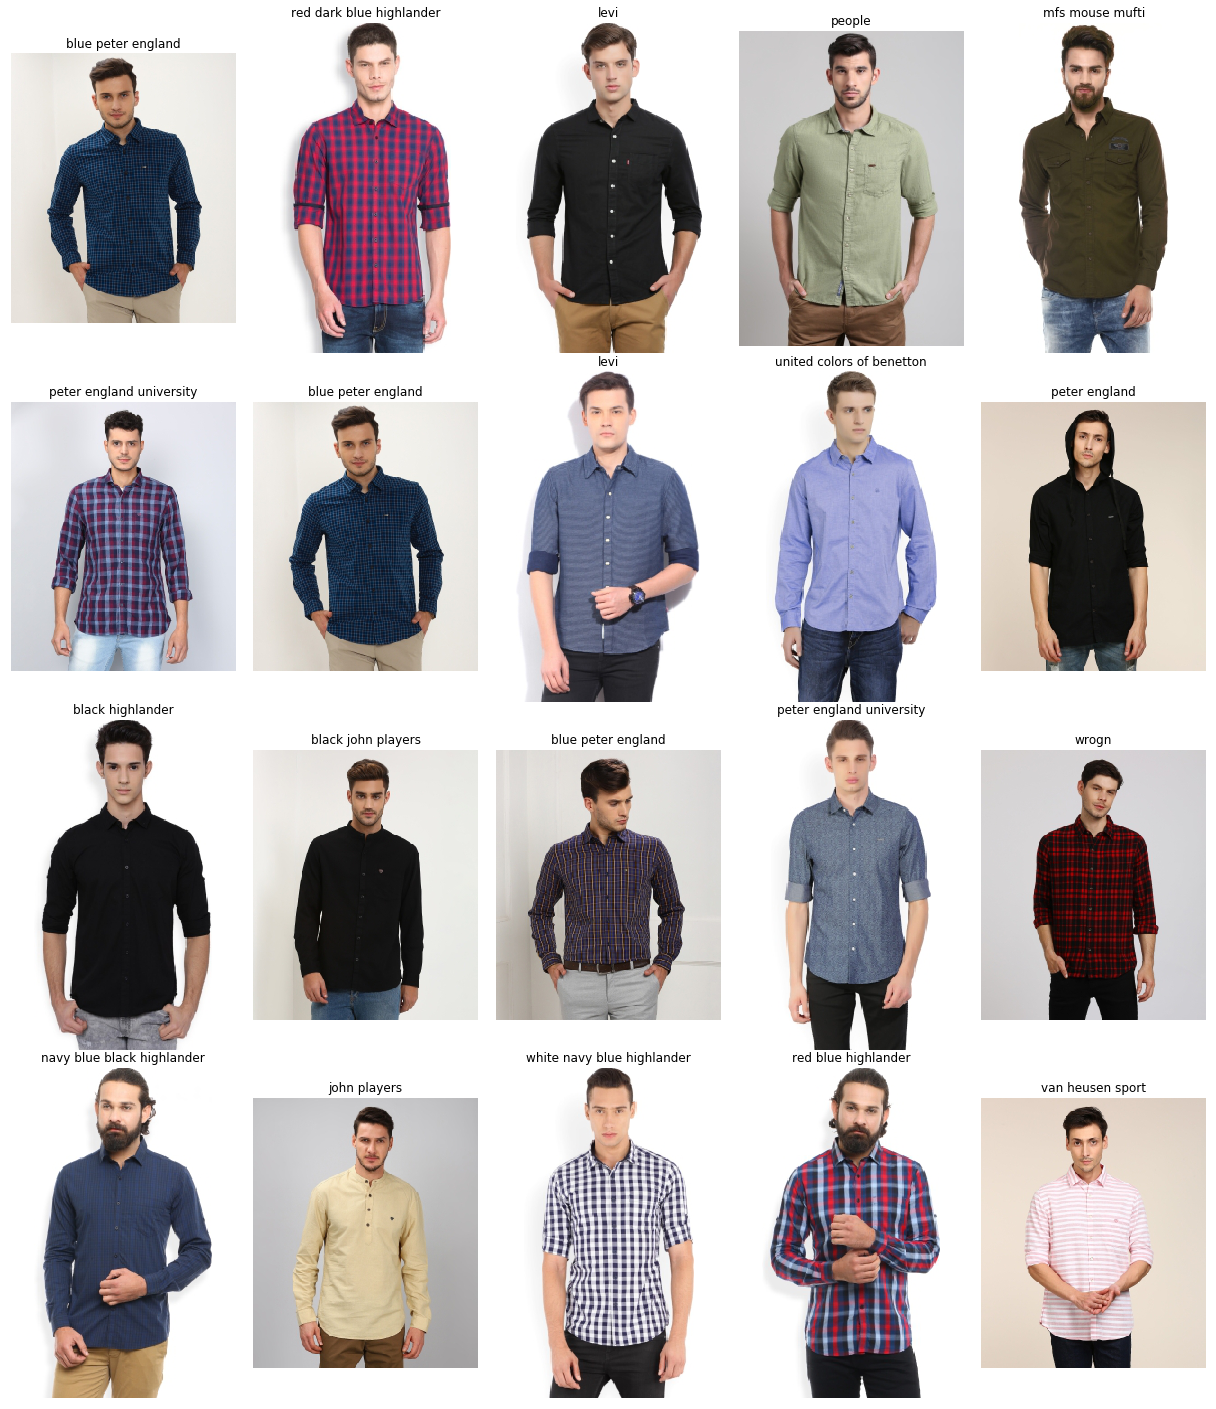

In [75]:
plot_images(rec_fsn)